In [1]:
import os

from sklearn.preprocessing import LabelEncoder

from tqdm import tqdm
import timm

import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

from src.model import NW_CNN
from src.dataset import CropsPytorchDataset
from src.utils import Averager

In [2]:
torch.manual_seed(42)
le = LabelEncoder()
le.fit(['human-hold-bicycle', 'human-ride-bicycle', 'human-ride-motorcycle', 'human-walk-bicycle', 'human-hold-motorcycle'])
train_dataset = CropsPytorchDataset(img_dir='data/annotated_data/clips/', anno_file='data_anno/training_data.csv', label_encoder=le, weights=True)
val_dataset = CropsPytorchDataset(img_dir='data/annotated_data/clips/', anno_file='data_anno/testing_data.csv', label_encoder=le, weights=True)

train_dataloader = DataLoader(train_dataset, batch_size=40, sampler=train_dataset.weighted_sampler)
val_dataloader = DataLoader(val_dataset, batch_size=40, sampler=val_dataset.weighted_sampler)

In [3]:
out_dir = 'products/models'
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)

In [4]:
model = timm.create_model('resnet50', num_classes = 5, in_chans=1)
# model = NW_CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

device = torch.device('cuda')
model.train()
model.to(device);

In [5]:
#In case you want to continue training from checkpoint
# model = torch.load('products/models/NW_CNN_checkpoint.pth')
# model.train()
# model.to(device)

In [5]:
train_losses = []
val_losses = []
train_loss_hist = Averager()
val_loss_hist = Averager()
best_valid_loss=float('inf')
max_epochs = 30

for epoch in range(max_epochs):  # loop over the dataset multiple times
    print(f"\nEPOCH {epoch} of {max_epochs}")
    train_loss_hist.reset()
    prog_bar = tqdm(train_dataloader, total=len(train_dataloader), leave=True)
    for inputs, labels in prog_bar:
        labels = torch.squeeze(labels, dim=1).long().to(device)
        inputs = inputs.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_loss_hist.send(loss)
        loss.backward()
        optimizer.step()

   
    print(f"Epoch #{epoch} train loss: {train_loss_hist.value:.3f}")
    train_losses.append(train_loss_hist.value)

    val_loss_hist.reset()  
    
    prog_bar = tqdm(val_dataloader, total=len(val_dataloader), leave=True)
    for inputs, labels in prog_bar:
        labels = torch.squeeze(labels, dim=1).long().to(device)
        inputs = inputs.to(device)
        outputs = model(inputs)
        with torch.no_grad():
            loss = criterion(outputs, labels)
        val_loss_hist.send(loss)      
     
    print(f"Epoch #{epoch} validation loss: {val_loss_hist.value:.3f}")
    val_losses.append(val_loss_hist.value)

    #Saving best model
    if val_loss_hist.value < best_valid_loss:
        best_valid_loss = val_loss_hist.value
        print(f"\nBest validation loss: {best_valid_loss}")
        print(f"\nSaving best model for epoch: {epoch}\n")
        torch.save(model, os.path.join('products/models', f'weighted_resnet50_checkpoint.pth'))

    
print('Finished Training')


EPOCH 0 of 30


100%|██████████| 192/192 [00:20<00:00,  9.29it/s]


Epoch #0 train loss: 1.477


100%|██████████| 88/88 [00:07<00:00, 11.32it/s]


Epoch #0 validation loss: 1.497

Best validation loss: 1.49721360206604

Saving best model for epoch: 0


EPOCH 1 of 30


100%|██████████| 192/192 [00:19<00:00,  9.87it/s]


Epoch #1 train loss: 1.325


100%|██████████| 88/88 [00:07<00:00, 12.08it/s]


Epoch #1 validation loss: 1.436

Best validation loss: 1.4360582828521729

Saving best model for epoch: 1


EPOCH 2 of 30


100%|██████████| 192/192 [00:18<00:00, 10.26it/s]


Epoch #2 train loss: 1.208


100%|██████████| 88/88 [00:07<00:00, 12.00it/s]


Epoch #2 validation loss: 1.369

Best validation loss: 1.3686306476593018

Saving best model for epoch: 2


EPOCH 3 of 30


100%|██████████| 192/192 [00:18<00:00, 10.21it/s]


Epoch #3 train loss: 1.107


100%|██████████| 88/88 [00:07<00:00, 12.19it/s]


Epoch #3 validation loss: 1.295

Best validation loss: 1.2949905395507812

Saving best model for epoch: 3


EPOCH 4 of 30


100%|██████████| 192/192 [00:19<00:00,  9.89it/s]


Epoch #4 train loss: 1.025


100%|██████████| 88/88 [00:07<00:00, 11.88it/s]


Epoch #4 validation loss: 1.299

EPOCH 5 of 30


100%|██████████| 192/192 [00:19<00:00,  9.96it/s]


Epoch #5 train loss: 0.949


100%|██████████| 88/88 [00:07<00:00, 12.00it/s]


Epoch #5 validation loss: 1.233

Best validation loss: 1.2334867715835571

Saving best model for epoch: 5


EPOCH 6 of 30


100%|██████████| 192/192 [00:19<00:00, 10.07it/s]


Epoch #6 train loss: 0.896


100%|██████████| 88/88 [00:07<00:00, 12.10it/s]


Epoch #6 validation loss: 1.178

Best validation loss: 1.177825927734375

Saving best model for epoch: 6


EPOCH 7 of 30


100%|██████████| 192/192 [00:18<00:00, 10.19it/s]


Epoch #7 train loss: 0.840


100%|██████████| 88/88 [00:07<00:00, 12.35it/s]


Epoch #7 validation loss: 1.174

Best validation loss: 1.1742169857025146

Saving best model for epoch: 7


EPOCH 8 of 30


100%|██████████| 192/192 [00:19<00:00, 10.04it/s]


Epoch #8 train loss: 0.814


100%|██████████| 88/88 [00:07<00:00, 12.32it/s]


Epoch #8 validation loss: 1.169

Best validation loss: 1.1686270236968994

Saving best model for epoch: 8


EPOCH 9 of 30


100%|██████████| 192/192 [00:19<00:00, 10.01it/s]


Epoch #9 train loss: 0.782


100%|██████████| 88/88 [00:07<00:00, 11.64it/s]


Epoch #9 validation loss: 1.187

EPOCH 10 of 30


100%|██████████| 192/192 [00:18<00:00, 10.18it/s]


Epoch #10 train loss: 0.745


100%|██████████| 88/88 [00:07<00:00, 11.86it/s]


Epoch #10 validation loss: 1.222

EPOCH 11 of 30


100%|██████████| 192/192 [00:18<00:00, 10.40it/s]


Epoch #11 train loss: 0.716


100%|██████████| 88/88 [00:07<00:00, 12.15it/s]


Epoch #11 validation loss: 1.173

EPOCH 12 of 30


100%|██████████| 192/192 [00:18<00:00, 10.27it/s]


Epoch #12 train loss: 0.714


100%|██████████| 88/88 [00:07<00:00, 12.13it/s]


Epoch #12 validation loss: 1.200

EPOCH 13 of 30


100%|██████████| 192/192 [00:19<00:00,  9.97it/s]


Epoch #13 train loss: 0.684


100%|██████████| 88/88 [00:07<00:00, 12.36it/s]


Epoch #13 validation loss: 1.255

EPOCH 14 of 30


100%|██████████| 192/192 [00:19<00:00, 10.03it/s]


Epoch #14 train loss: 0.652


100%|██████████| 88/88 [00:07<00:00, 12.23it/s]


Epoch #14 validation loss: 1.250

EPOCH 15 of 30


100%|██████████| 192/192 [00:18<00:00, 10.39it/s]


Epoch #15 train loss: 0.633


100%|██████████| 88/88 [00:07<00:00, 11.62it/s]


Epoch #15 validation loss: 1.226

EPOCH 16 of 30


100%|██████████| 192/192 [00:18<00:00, 10.19it/s]


Epoch #16 train loss: 0.613


100%|██████████| 88/88 [00:07<00:00, 12.10it/s]


Epoch #16 validation loss: 1.321

EPOCH 17 of 30


100%|██████████| 192/192 [00:19<00:00, 10.05it/s]


Epoch #17 train loss: 0.590


100%|██████████| 88/88 [00:07<00:00, 12.32it/s]


Epoch #17 validation loss: 1.295

EPOCH 18 of 30


100%|██████████| 192/192 [00:18<00:00, 10.13it/s]


Epoch #18 train loss: 0.581


100%|██████████| 88/88 [00:07<00:00, 12.30it/s]


Epoch #18 validation loss: 1.301

EPOCH 19 of 30


100%|██████████| 192/192 [00:18<00:00, 10.11it/s]


Epoch #19 train loss: 0.566


100%|██████████| 88/88 [00:07<00:00, 12.15it/s]


Epoch #19 validation loss: 1.362

EPOCH 20 of 30


100%|██████████| 192/192 [00:18<00:00, 10.38it/s]


Epoch #20 train loss: 0.554


100%|██████████| 88/88 [00:07<00:00, 11.82it/s]


Epoch #20 validation loss: 1.306

EPOCH 21 of 30


100%|██████████| 192/192 [00:20<00:00,  9.27it/s]


Epoch #21 train loss: 0.540


100%|██████████| 88/88 [00:07<00:00, 11.51it/s]


Epoch #21 validation loss: 1.380

EPOCH 22 of 30


100%|██████████| 192/192 [00:20<00:00,  9.46it/s]


Epoch #22 train loss: 0.518


100%|██████████| 88/88 [00:07<00:00, 11.46it/s]


Epoch #22 validation loss: 1.365

EPOCH 23 of 30


100%|██████████| 192/192 [00:19<00:00,  9.69it/s]


Epoch #23 train loss: 0.499


100%|██████████| 88/88 [00:07<00:00, 11.57it/s]


Epoch #23 validation loss: 1.395

EPOCH 24 of 30


100%|██████████| 192/192 [00:19<00:00,  9.82it/s]


Epoch #24 train loss: 0.502


100%|██████████| 88/88 [00:07<00:00, 11.45it/s]


Epoch #24 validation loss: 1.422

EPOCH 25 of 30


100%|██████████| 192/192 [00:19<00:00,  9.76it/s]


Epoch #25 train loss: 0.481


100%|██████████| 88/88 [00:07<00:00, 11.49it/s]


Epoch #25 validation loss: 1.433

EPOCH 26 of 30


100%|██████████| 192/192 [00:19<00:00,  9.88it/s]


Epoch #26 train loss: 0.472


100%|██████████| 88/88 [00:07<00:00, 12.20it/s]


Epoch #26 validation loss: 1.353

EPOCH 27 of 30


100%|██████████| 192/192 [00:19<00:00, 10.09it/s]


Epoch #27 train loss: 0.456


100%|██████████| 88/88 [00:07<00:00, 12.22it/s]


Epoch #27 validation loss: 1.461

EPOCH 28 of 30


100%|██████████| 192/192 [00:18<00:00, 10.40it/s]


Epoch #28 train loss: 0.451


100%|██████████| 88/88 [00:07<00:00, 12.08it/s]


Epoch #28 validation loss: 1.356

EPOCH 29 of 30


100%|██████████| 192/192 [00:18<00:00, 10.39it/s]


Epoch #29 train loss: 0.432


100%|██████████| 88/88 [00:07<00:00, 11.69it/s]

Epoch #29 validation loss: 1.348
Finished Training


In [13]:
#logging losses
train_losses_np = [train_loss.detach().cpu().numpy().item() for train_loss in train_losses]
val_losses_np = [val_loss.detach().cpu().numpy().item() for val_loss in val_losses]
with open(os.path.join(out_dir, 'weighted_resnet50_train_loss.txt'), 'w') as f:
    for item in train_losses_np:
        f.write("%s\n" % item)

with open(os.path.join(out_dir, 'weighted_resnet50_val_loss.txt'), 'w') as f:
    for item in val_losses_np:
        f.write("%s\n" % item)

In [6]:
model = torch.load('products/models/weighted_resnet50_checkpoint.pth')
model.to(torch.device('cpu'))
model.eval();

In [47]:
#Extracting testing results to be used with sklearn metrics
import time
import numpy as np

test_dataset = CropsPytorchDataset(img_dir='data/annotated_data/clips/', anno_file='data_anno/testing_data.csv', label_encoder=le, find_pairs=True, weights=False)
test_dataloader = DataLoader(test_dataset, batch_size=40, shuffle=False)

start = time.time()
targets = []
predictions = []
for i, (crop, target) in enumerate(test_dataloader):
    prediction = torch.argmax(model(crop), dim=1)
    target = torch.squeeze(target)
    predictions = np.concatenate((predictions, prediction.numpy()))
    targets = np.concatenate((targets, target.numpy()))
end = time.time()

37.31300163269043


Inference processing time on cpu: 39.06s
Accuracy score: 0.43

Precision scores: [0.37 0.01 0.95 0.09 0.1 ]
Macro precision: 0.31

Recall scores: [0.72 0.5  0.4  0.56 0.41]
Macro recall: 0.52

F1 scores: [0.49 0.02 0.56 0.16 0.16]
Macro F1: 0.28


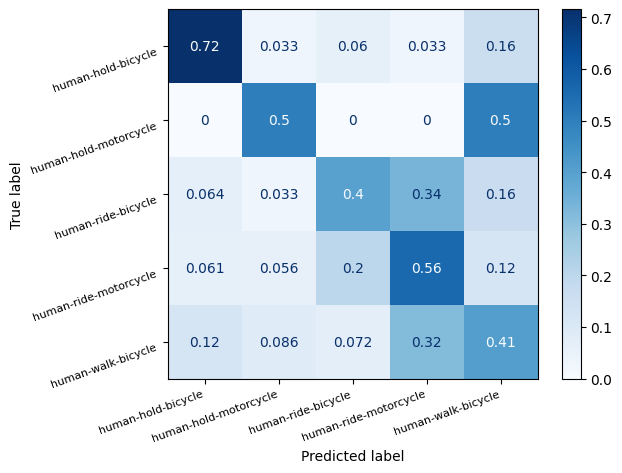

In [46]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score

print(f'Inference processing time on cpu: {round(end-start, 2)}s')
print(f'Accuracy score: {round(accuracy_score(targets, predictions), 2)}')
print(f'\nPrecision scores: {precision_score(targets, predictions, average=None).round(2)}')
print(f"Macro precision: {precision_score(targets, predictions, average='macro').round(2)}")

print(f'\nRecall scores: {recall_score(targets, predictions, average=None).round(2)}')
print(f"Macro recall: {recall_score(targets, predictions, average='macro').round(2)}")

print(f'\nF1 scores: {f1_score(targets, predictions, average=None).round(2)}')
print(f"Macro F1: {f1_score(targets, predictions, average='macro').round(2)}")


cm = confusion_matrix(targets, predictions, normalize='true')
disp = ConfusionMatrixDisplay(cm, display_labels=le.inverse_transform([0, 1, 2, 3, 4]))
disp.plot(cmap='Blues')
plt.yticks(rotation=20, va='top', fontsize=8)
plt.xticks(rotation=20, ha='right', fontsize=8)
plt.show()

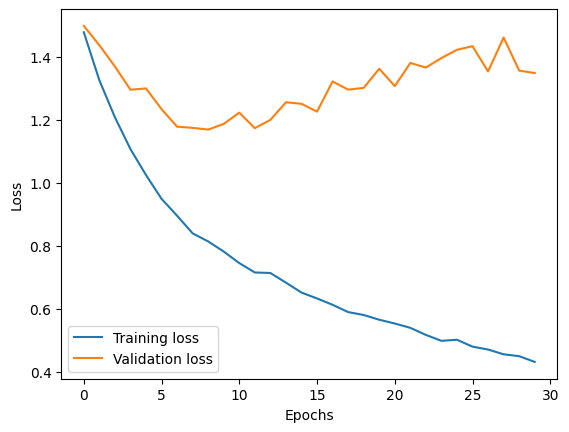

In [58]:
with open('products/models/weighted_resnet50_train_loss.txt', 'r') as f:
    data =  f.read()
    train_plot = data.split('\n')
    train_plot = [float(loss) for loss in train_plot]

with open('products/models/weighted_resnet50_val_loss.txt', 'r') as f:
    data =  f.read()
    val_plot = data.split('\n')
    val_plot = [float(loss) for loss in val_plot]

plt.plot(range(30), train_plot, label='Training loss')
plt.plot(range(30), val_plot, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
